In [1]:
print("hello")

hello


In [2]:
!nvidia-smi

Sun Sep 29 19:01:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:47:00.0 Off |                    0 |
| N/A   22C    P0              55W / 400W |      3MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# **Lab 6 Transfer Learning & Hyperparameter Tuning**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset,Dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import cv2
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

seed = 4912
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Data Preparation
Complete the class `CustomImageDataset()` that `__getitem__` return ***noisy blury*** image and ***ground truth*** image.
Please ensure that the final image is in RGBscale and has a size of 128x128.

In [5]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, gauss_noise=False, gauss_blur=False, resize=128, p=0.5):
        self.p = p  # Probability for applying noise/blur
        self.resize = resize  # Final image size
        self.gauss_noise = gauss_noise  # Whether to apply Gaussian noise
        self.gauss_blur = gauss_blur  # Whether to apply Gaussian blur
        self.image_paths = image_paths  # List of image paths

        # Transformation to resize the image to the required size
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((resize, resize)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image from the file path
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)  # Read image using OpenCV (BGR format)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Apply transformations to get the ground truth image (resize and convert to tensor)
        gt_image = self.transform(image)

        # Add Gaussian noise to the image with probability p
        if self.gauss_noise and random.random() < self.p:
            noise_mean = random.uniform(-50, 50) / 255.0  # Random noise mean in range [-50, 50] scaled
            image = random_noise(image, mode='gaussian', mean=noise_mean, var=0.01)  # Add Gaussian noise
            image = np.array(255 * image, dtype='uint8')

        # Apply Gaussian blur to the image with probability p
        if self.gauss_blur and random.random() < self.p:
            blur_kernel_size = random.choice(range(3, 12, 2))  # Random kernel size in the range [3, 11]
            image = cv2.GaussianBlur(image, (blur_kernel_size, blur_kernel_size), 5)  # Apply Gaussian blur

        # Resize the noisy image and convert to tensor
        noisy_image = self.transform(image)

        return noisy_image, gt_image
### END CODE HERE ###

In [6]:
### START CODE HERE ###
def imshow_grid(images, ncols=4):
    fig, axes = plt.subplots(nrows=len(images) // ncols, ncols=ncols, figsize=(12, 12))
    axes = axes.flatten()
    
    for img, ax in zip(images, axes):
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # Convert the image to the right format
        ax.axis('off')

    plt.tight_layout()
    plt.show()
### END CODE HERE ###

In [6]:
# import tarfile

# # Specify the path to your tar.gz file
# file_path = 'data.tar.gz'

# # Open the tar.gz file
# with tarfile.open(file_path, 'r:gz') as tar:
#     # Extract all contents into a directory
#     tar.extractall(path='extracted_data')

In [7]:
### START CODE HERE ###
relative_dir = "extracted_data/data/img_align_celeba"
data_dir = os.path.abspath(relative_dir)
print(data_dir)
image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if img.endswith(".jpg")]
print(len(image_paths))

dataset = CustomImageDataset(image_paths, gauss_noise=True, gauss_blur=5, resize=128, p=0.5)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
### END CODE HERE ###

/home/tniwatw/Lab/Lab6/extracted_data/data/img_align_celeba
30000


Noisy blury images


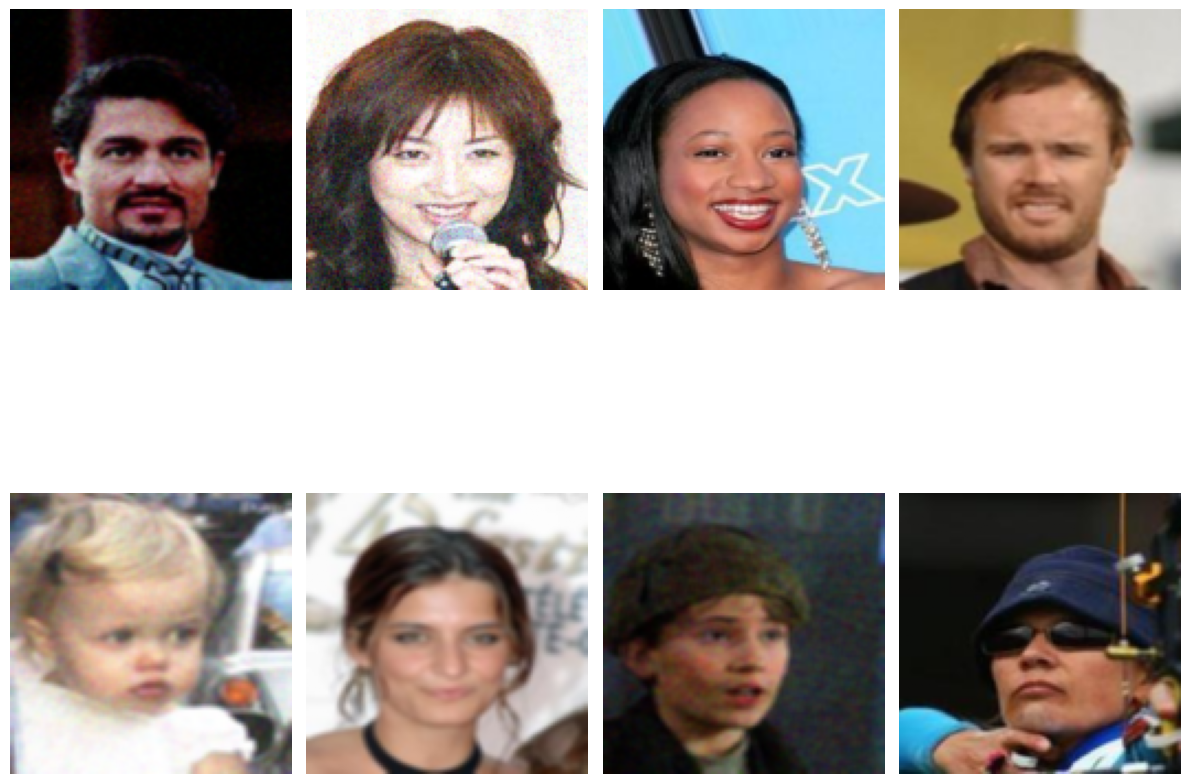

Ground Truth images


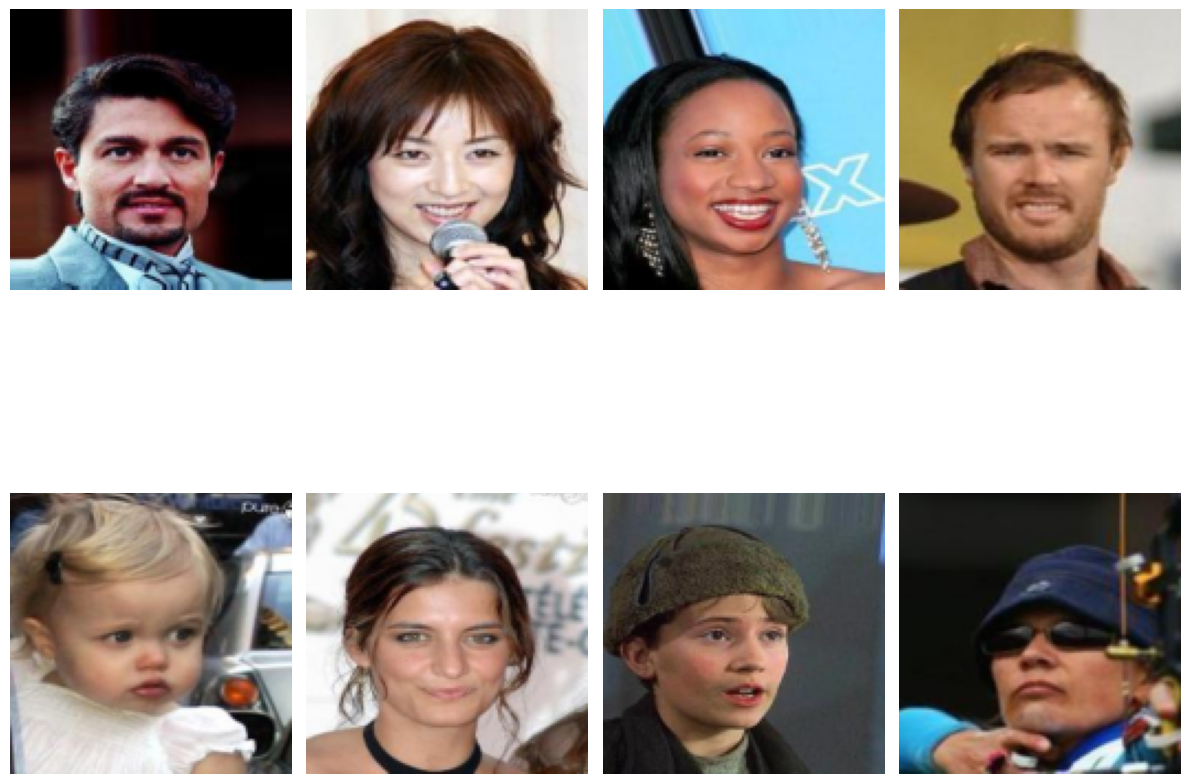

In [8]:
### START CODE HERE ###
batch, gt_img = next(iter(dataloader)) 

# Display a batch of noisy images and ground truth images
print("Noisy blury images")
imshow_grid(batch)
print("Ground Truth images")
imshow_grid(gt_img)
### END CODE HERE ###

## Create Autoencoder model
You can design your own Autoencoder model with a customizable number of downsampling and upsampling blocks by passing a list of channel numbers for each layer based on the provided code below. However, please maintain the concept of 'Autoencoder'.

In [8]:
### START CODE HERE ###
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DownSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, channels=[64, 128, 256], input_channels=3, output_channels=3):
        super(Autoencoder, self).__init__()
        
        # Encoder: Downsampling layers
        self.encoder = nn.ModuleList()
        in_channels = input_channels
        for out_channels in channels:
            self.encoder.append(DownSamplingBlock(in_channels, out_channels))
            in_channels = out_channels
        
        # Decoder: Upsampling layers (reverse of the encoder)
        self.decoder = nn.ModuleList()
        for out_channels in reversed(channels[:-1]):
            self.decoder.append(UpSamplingBlock(in_channels, out_channels))
            in_channels = out_channels
        # Final layer to map back to the original number of channels
        self.decoder.append(UpSamplingBlock(in_channels, output_channels))

    def forward(self, x):
        # Encoding
        for layer in self.encoder:
            x = layer(x)
        
        # Decoding
        for layer in self.decoder:
            x = layer(x)
        
        return x
### END CODE HERE ###

## Train Autoencoder
Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the ***training loss, test loss,test PSNR, test SSIM***. Additionally, it should save the model at the last epoch.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The log should resemble this, but not be identical

```
🤖Training on cuda
🚀Training Epoch [1/1]: 100%|██████████| 1313/1313 [01:45<00:00, 12.41batch/s, loss=0.0102] 
📄Testing: 100%|██████████| 563/563 [01:10<00:00,  7.95batch/s, loss=0.0106, psnr=16.7, ssim=0.348] 
Summary :
	Train	avg_loss: 0.017262999383663165
	Test	avg_loss: 0.010476540363861867 
                PSNR : 16.839487147468034 
                SSIM : 0.36090552368883694
...
```

</details>

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [PSNR & SSIM](https://ieeexplore.ieee.org/document/5596999)

In [9]:
### START CODE HERE ###
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    print("🤖Training on", device)
    model = model.to(device)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        train_bar = tqdm(train_loader, desc=f'🚀Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        for images, gt in train_bar:
            images, gt = images.to(device), gt.to(device)
            
            # Forward pass
            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, gt)
            loss.backward()
            opt.step()
            
            total_train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())
        
        avg_train_loss = total_train_loss / len(train_loader)
        
        # Testing phase
        model.eval()
        total_test_loss = 0
        total_psnr = 0
        total_ssim = 0
        
        test_bar = tqdm(test_loader, desc='📄Testing', unit='batch')
        with torch.no_grad():
            for images, gt in test_bar:
                images, gt = images.to(device), gt.to(device)
                
                outputs = model(images)
                loss = loss_fn(outputs, gt)
                total_test_loss += loss.item()
                
                # Convert outputs and gt to numpy arrays for PSNR and SSIM calculations
                outputs_np = outputs.permute(0, 2, 3, 1).cpu().numpy()
                gt_np = gt.permute(0, 2, 3, 1).cpu().numpy()
                
                # Calculate PSNR and SSIM for the batch
                batch_psnr = np.mean([psnr(gt_np[i], outputs_np[i]) for i in range(gt_np.shape[0])])
                
                # Set win_size to 3 and use channel_axis for SSIM, specifying data_range
                batch_ssim = np.mean([ssim(gt_np[i], outputs_np[i], win_size=3, channel_axis=-1, data_range=1.0) for i in range(gt_np.shape[0])])
                
                total_psnr += batch_psnr
                total_ssim += batch_ssim
                
                test_bar.set_postfix(loss=loss.item(), psnr=batch_psnr, ssim=batch_ssim)
        
        avg_test_loss = total_test_loss / len(test_loader)
        avg_psnr = total_psnr / len(test_loader)
        avg_ssim = total_ssim / len(test_loader)
        
        # Log summary for the epoch
        print(f'Summary for Epoch {epoch+1}/{epochs}:')
        print(f'    Train    avg_loss: {avg_train_loss}')
        print(f'    Test     avg_loss: {avg_test_loss}')
        print(f'                PSNR : {avg_psnr}')
        print(f'                SSIM : {avg_ssim}')
        
        # Save model at the last epoch
        if epoch == epochs - 1 and checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved at {checkpoint_path}')

### END CODE HERE ###


Let's train your model with 2 epochs to verify that your train() function works properly. After that, we'll move on to the Hyperparameter Grid Search in the next part.

In [10]:
### START CODE HERE ###
# CODE FOR PRODUCTION USE
# -------------------------------------------------------------------------------------------------
## START CODE HERE ###
files = os.listdir(data_dir)
files = [os.path.join(data_dir, file) for file in files]

# Split the dataset into training and testing sets
train_files, test_files = train_test_split(files, test_size=0.3, shuffle=True, random_state=2024)

train_dataset = CustomImageDataset(train_files, gauss_noise=True, gauss_blur=True)
test_dataset = CustomImageDataset(test_files, gauss_noise=True, gauss_blur=True)
trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# -------------------------------------------------------------------------------------------------
### END CODE HERE ###

In [12]:
# #CODE FOR TESTING
# # -------------------------------------------------------------------------------------------------
# # List all image files in the directory
# files = os.listdir(data_dir)
# files = [os.path.join(data_dir, file) for file in files]

# # Define the size of the subsets
# train_size = 15  # Number of images for training
# test_size = 20  # Number of images for testing

# # Sample a small subset of files
# sampled_files = np.random.choice(files, size=train_size + test_size, replace=False)

# # Split the sampled files into training and testing sets
# train_files, test_files = train_test_split(sampled_files, test_size=test_size, random_state=42)


# # Create dataset objects with the option for augmentations like Gaussian noise and blur
# train_dataset = CustomImageDataset(train_files, gauss_noise=True, gauss_blur=5, resize=128, p=0.5)
# test_dataset = CustomImageDataset(test_files, gauss_noise=False, gauss_blur=None, resize=128, p=0.5)

# # Create DataLoaders for both training and testing datasets
# trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# testloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # Print the sizes of the datasets
# print(f"Number of training files: {len(train_files)}")
# print(f"Number of test files: {len(test_files)}")
# # -------------------------------------------------------------------------------------------------

In [11]:
### START CODE HERE ###
# # Initialize model, optimizer, and loss function
model = Autoencoder()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train the model
train(model, opt, loss_fn, trainloader, testloader, epochs=10, checkpoint_path='autoencoder.pth', device='cuda' if torch.cuda.is_available() else 'cpu')

### END CODE HERE ###

---

## **Hyperparameter Grid Search with Raytune**

*If you have access to APEX, I would recommend converting this part into a Python file and submitting the job to run on APEX using SBATCH. This process may take a considerable amount of time.*

You can import additional Ray Tune tools as you want, such as schedulers, search algorithms, etc. Further information on the usage of Ray Tune can be found [here](https://docs.ray.io/en/latest/tune/index.html).

In [14]:
# %pip install ray

Complete the `train_raytune()` function below, following the [quick start guide](https://docs.ray.io/en/latest/tune/index.html). This function will be passed to the `tune.Tuner`.

In [12]:
import ray
from ray import tune
from ray.air import session
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from ray.air.config import RunConfig
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from ray.train import Checkpoint

ray.shutdown()

In [14]:
def train_raytune(config):
    # Define data loaders (use your dataset)
    transform = transforms.Compose([
        transforms.Resize(128),  # Resize to 128x128
        transforms.ToTensor()
    ])

    trainloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=16)
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=16)

    # Instantiate the model
    model = Autoencoder(channels=config['architecture'], input_channels=3, output_channels=3)
    model = model.to(config['device'])
    
    # Define optimizer
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)

    # Loss function
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(config['num_epochs']):
        model.train()
        total_train_loss = 0
        for images, _ in trainloader:  # Assuming ground truth is the same input for autoencoder
            images = images.to(config['device'])

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(trainloader)

        # Validation loop
        model.eval()
        total_val_loss = 0
        total_psnr = 0
        total_ssim = 0
        with torch.no_grad():
            for images, _ in testloader:
                images = images.to(config['device'])
                outputs = model(images)
                loss = criterion(outputs, images)
                total_val_loss += loss.item()

                # Convert images to numpy for PSNR and SSIM calculation
                images_np = images.cpu().numpy()
                outputs_np = outputs.cpu().numpy()

                # Calculate PSNR and SSIM for each image in the batch
                batch_psnr = 0
                batch_ssim = 0
                for i in range(images_np.shape[0]):
                    img_gt = images_np[i].transpose(1, 2, 0)  # HWC format for PSNR and SSIM
                    img_pred = outputs_np[i].transpose(1, 2, 0)
                    
                    # PSNR and SSIM calculation with data_range specified
                    batch_psnr += psnr(img_gt, img_pred, data_range=img_gt.max() - img_gt.min())
                    batch_ssim += ssim(img_gt, img_pred, data_range=1.0, win_size=3, channel_axis=-1)

                total_psnr += batch_psnr / images_np.shape[0]
                total_ssim += batch_ssim / images_np.shape[0]

        avg_val_loss = total_val_loss / len(testloader)
        avg_val_psnr = total_psnr / len(testloader)
        avg_val_ssim = total_ssim / len(testloader)

        # Report metrics to Ray Tune
        session.report({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_psnr": avg_val_psnr,
            "val_ssim": avg_val_ssim
        })


Initialize Ray, define the search space, and resources.

Resource : 
- [A Guide To Parallelism and Resources for Ray Tune](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html#:~:text=A%20Guide%20To%20Parallelism%20and%20Resources%20for%20Ray%20Tune) 
- [Working with Tune Search Spaces](https://docs.ray.io/en/latest/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial:~:text=Working%20with%20Tune%20Search%20Spaces)
- [How to configure logging in Tune?](https://docs.ray.io/en/latest/tune/tutorials/tune-output.html) 
- [Tune Trial Schedulers (`tune.schedulers`)](https://docs.ray.io/en/latest/tune/api/schedulers.html#tune-scheduler-pbt:~:text=Tune%20Trial...-,Tune%20Trial%20Schedulers%20(tune.schedulers),-%23)

**Search Space:**
- `architecture`:<br>
    Feature map dimensions for convolutional layers<br>
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with more depth, starting from 64 and ending at 512.
- `learning rates (lr)`:
    - [1e-3, 8e-4, 1e-4, 1e-2]: Test a wide range of learning rates to evaluate model performance, from 1e-3 (typical) to a more aggressive 1e-2 or conservative 1e-4.
- `batch size`:
    - [16, 32]: Explore smaller batch sizes to evaluate their impact on gradient estimation and memory usage.
- `number of epochs`:
    - `[10, 50, 100]`: Allow short and long training sessions, from quick evaluations (10 epochs) to more extensive training (100 epochs).
- `optimizers (opts)`:
    - `["Adam", "SGD"]`: Compare two popular optimization algorithms: Adam for adaptive learning rates and SGD for momentum-based updates.

In [19]:
# Load the checkpoint file
# Relative path
checkpoint_path = "ray_results/grid_search/train_raytune_2024-09-25_15-05-14"

# Convert to absolute path
absolute_path = os.path.abspath(checkpoint_path)
analysis = tune.ExperimentAnalysis(absolute_path)

# Get all trials
all_trials = analysis.trials

# Filter out completed trials (status is TERMINATED or COMPLETE)
valid_trials = [trial for trial in all_trials if trial.status in ('TERMINATED', 'COMPLETE')]

# Print the number of all trials and the number of valid completed trials
num_all_trials = len(all_trials)
num_completed_trials = len(valid_trials)
print(f"Number of completed trials: {num_completed_trials} from all trials: {num_all_trials}")

# Check if there are any valid trials
if valid_trials:
    # Find the best trial using the specified metric and mode
    best_trial = analysis.get_best_trial(metric="val_psnr", mode="max")

    if best_trial is not None:
        best_config = best_trial.config
        print(f"Best Trial: {best_trial}")
    else:
        print("No best trial found for the specified metric and mode.")
else:
    print("No valid completed trials found.")


2024-09-29 15:02:48,554	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 90 trial(s):
- train_raytune_e5418_00113: FileNotFoundError('Could not fetch metrics for train_raytune_e5418_00113: both result.json and progress.csv were not found at /home/tniwatw/Lab/Lab6/ray_results/grid_search/train_raytune_2024-09-25_15-05-14/train_raytune_e5418_00113')
- train_raytune_e5418_00130: FileNotFoundError('Could not fetch metrics for train_raytune_e5418_00130: both result.json and progress.csv were not found at /home/tniwatw/Lab/Lab6/ray_results/grid_search/train_raytune_2024-09-25_15-05-14/train_raytune_e5418_00130')
- train_raytune_e5418_00126: FileNotFoundError('Could not fetch metrics for train_raytune_e5418_00126: both result.json and progress.csv were not found at /home/tniwatw/Lab/Lab6/ray_results/grid_search/train_raytune_2024-09-25_15-05-14/train_raytune_e5418_00126')
- train_raytune_e5418_00055: FileNotFoundError('Could not fetch metrics for train_raytune_e5418_00055: bo

Number of completed trials: 51 from all trials: 144
Best Trial: train_raytune_e5418_00049


In [ ]:
# #CODE FOR TESTING
# # -------------------------------------------------------------------------------------------------
# ### START CODE HERE ###
# relative_dir_result = "ray_results/grid_search/"
# if not os.path.exists(relative_dir_result):
#     os.makedirs(relative_dir_result)
# absolute_dir_result = os.path.abspath(relative_dir_result)

# # Define a simple trial directory name creator to shorten paths
# def trial_dirname_creator(trial):
#     return f"{trial.trainable_name}_{trial.trial_id}"

# # Initialize Ray
# ray.init(num_gpus=1)

# # Fix the device key and ensure it's included in the config
# config = {
#     'architecture': tune.grid_search([
#         [32, 64, 128],
#     ]),
#     'lr': tune.grid_search([1e-3]),
#     'batch_size': tune.grid_search([16]),
#     'num_epochs': tune.grid_search([1]),
#     'optimizer': tune.grid_search(['Adam']),
#     'input_channels': 3,
#     'output_channels': 3,
#     'device': 'cuda' if torch.cuda.is_available() else 'cpu'  # Make sure device is included
# }

# # Define Tuner with custom trial_dirname_creator to shorten directory paths
# tuner = tune.Tuner(
#     trainable=train_raytune,
#     param_space=config,
#     tune_config=tune.TuneConfig(
#         metric="val_psnr",
#         mode="max",
#         num_samples=1,  # Reduce to 1 sample for fast iteration
#         trial_dirname_creator=trial_dirname_creator
#     ),
#     run_config=RunConfig(
#         storage_path=absolute_dir_result
#     )
# )

# # Run the Tuner
# result = tuner.fit()
# ### END CODE HERE ###

In [ ]:
ray.shutdown()

In [ ]:
# CODE FOR PRODUCTION USE
# -------------------------------------------------------------------------------------------------
## START CODE HERE ###
relative_dir_result = "ray_results/grid_search/"
if not os.path.exists(relative_dir_result):
    os.makedirs(relative_dir_result)
absolute_dir_result = os.path.abspath(relative_dir_result)

# Define a simple trial directory name creator to shorten paths
def trial_dirname_creator(trial):
    return f"{trial.trainable_name}_{trial.trial_id}"

# Initialize Ray
ray.init(num_gpus=1)


# Fix the device key and ensure it's included in the config
config = {
    'architecture': tune.grid_search([
        [32, 64, 128],
        [64, 128, 256],
        [64, 128, 256, 512]
    ]),
    'lr': tune.grid_search([1e-3, 8e-4, 1e-4, 1e-2]),
    'batch_size': tune.grid_search([16, 32]),
    'num_epochs': tune.grid_search([10, 50, 100]),
    'optimizer': tune.grid_search(['Adam', 'SGD']),
    'input_channels': 3,
    'output_channels': 3,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'  # Make sure device is included
}

# Define Tuner with custom trial_dirname_creator to shorten directory paths
tuner = tune.Tuner(
    tune.with_resources(train_raytune, resources={"gpu": 0.33}),
    param_space=config,
    tune_config=tune.TuneConfig(
        metric="val_psnr",
        mode="max",
        num_samples=1,  # Reduce to 1 sample for fast iteration
        trial_dirname_creator=trial_dirname_creator,
    ),
    run_config=RunConfig(
        storage_path=absolute_dir_result,
    )
)


# Run the Tuner
result = tuner.fit()
## END CODE HERE ###

Restore the result from path of ray resule directory

In [22]:
### START CODE HERE ###
import glob

relative_dir_result = "ray_results/grid_search/"
if not os.path.exists(relative_dir_result):
    os.makedirs(relative_dir_result)
absolute_dir_result = os.path.abspath(relative_dir_result)

# Get the most recently modified directory
latest_path = max(glob.glob(os.path.join(absolute_dir_result, '*/')), key=os.path.getmtime)

# Get the directory name (last part of the path)
latest_directory_name = os.path.basename(os.path.normpath(latest_path))

# Print the latest directory name
print(f"The latest directory in {relative_dir_result}: {latest_directory_name}")

# Load the checkpoint file
# Relative path
checkpoint_path = os.path.join(relative_dir_result, latest_directory_name)
absolute_checkpoint_path = os.path.abspath(checkpoint_path)

analysis = tune.ExperimentAnalysis(absolute_checkpoint_path)

# Get all trials
all_trials = analysis.trials

# Filter out completed trials (status is TERMINATED or COMPLETE)
valid_trials = [trial for trial in all_trials if trial.status in ('TERMINATED', 'COMPLETE')]

# Print the number of all trials and the number of valid completed trials
num_all_trials = len(all_trials)
num_completed_trials = len(valid_trials)
print(f"Number of completed trials: {num_completed_trials} from all trials: {num_all_trials}")

# Check if there are any valid trials
if valid_trials:
    # Find the best trial using the specified metric and mode
    best_trial = analysis.get_best_trial(metric="val_psnr", mode="max")

    if best_trial is not None:
        best_config = best_trial.config
        print(f"Best Trial: {best_trial}")
    else:
        print("No best trial found for the specified metric and mode.")
else:
    print("No valid completed trials found.")

### END CODE HERE ###

The latest directory in ray_results/grid_search/: train_raytune_2024-09-25_15-05-14


2024-09-29 15:06:42,650	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 90 trial(s):
- train_raytune_e5418_00113: FileNotFoundError('Could not fetch metrics for train_raytune_e5418_00113: both result.json and progress.csv were not found at /home/tniwatw/Lab/Lab6/ray_results/grid_search/train_raytune_2024-09-25_15-05-14/train_raytune_e5418_00113')
- train_raytune_e5418_00130: FileNotFoundError('Could not fetch metrics for train_raytune_e5418_00130: both result.json and progress.csv were not found at /home/tniwatw/Lab/Lab6/ray_results/grid_search/train_raytune_2024-09-25_15-05-14/train_raytune_e5418_00130')
- train_raytune_e5418_00126: FileNotFoundError('Could not fetch metrics for train_raytune_e5418_00126: both result.json and progress.csv were not found at /home/tniwatw/Lab/Lab6/ray_results/grid_search/train_raytune_2024-09-25_15-05-14/train_raytune_e5418_00126')
- train_raytune_e5418_00055: FileNotFoundError('Could not fetch metrics for train_raytune_e5418_00055: bo

Number of completed trials: 51 from all trials: 144
Best Trial: train_raytune_e5418_00049


Get the report from Grid Search to CSV file.

In [32]:
print("🎉[INFO] Training is done!")
print("Best config is:", best_trial.config)
print("Best result is:", best_trial.last_result)

# Use the analysis object to create a DataFrame
df = analysis.dataframe()  # Get the DataFrame of all trials

# Define the folder and CSV name
csv_name = "grid_search.csv"

# Create the full path for the CSV file
csv_path = os.path.join(relative_dir_result, csv_name)

# Ensure the folder exists
os.makedirs(relative_dir_result, exist_ok=True)

# Save the DataFrame to a CSV file
df.to_csv(csv_path, index=False)

print(f"Results saved to: {csv_path}")

🎉[INFO] Training is done!
Best config is: {'architecture': [64, 128, 256], 'lr': 0.001, 'batch_size': 16, 'num_epochs': 100, 'optimizer': 'Adam', 'input_channels': 3, 'output_channels': 3, 'device': 'cuda'}
Best result is: {'train_loss': 0.0017341222872593002, 'val_loss': 0.0017634813756918532, 'val_psnr': 28.44117781983429, 'val_ssim': 0.7630671396699352, 'timestamp': 1727334591, 'checkpoint_dir_name': None, 'done': True, 'training_iteration': 100, 'trial_id': 'e5418_00049', 'date': '2024-09-26_14-09-51', 'time_this_iter_s': 148.1607837677002, 'time_total_s': 14642.166303157806, 'pid': 2115095, 'hostname': 'prism-4.apex.cmkl.ac.th', 'node_ip': '172.16.101.114', 'config': {'architecture': [64, 128, 256], 'lr': 0.001, 'batch_size': 16, 'num_epochs': 100, 'optimizer': 'Adam', 'input_channels': 3, 'output_channels': 3, 'device': 'cuda'}, 'time_since_restore': 14642.166303157806, 'iterations_since_restore': 100, 'experiment_tag': '49_architecture=64_128_256,batch_size=16,lr=0.0010,num_epoc

---

Train the Autoencoder models using the best hyperparameter set obtained from the grid search.

In [33]:
### START CODE HERE ###
# Train the Autoencoder with the best hyperparameters
best_config = best_trial.config
model = Autoencoder(channels=best_config['architecture'], input_channels=3, output_channels=3)
opt = optim.Adam(model.parameters(), lr=best_config['lr']) if best_config['optimizer'] == 'Adam' else optim.SGD(model.parameters(), lr=best_config['lr'], momentum=0.9)
loss_fn = nn.MSELoss()

# Define the filename
checkpoint_filename = "best_autoencoder_grid_search.pth"

# Create the full path for the checkpoint file
checkpoint_path = os.path.join(absolute_dir_result, checkpoint_filename)

train(model, opt, loss_fn, trainloader, testloader, epochs=best_config['num_epochs'], checkpoint_path=checkpoint_path, device=best_config['device'])
### END CODE HERE ###

🤖Training on cuda


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:16<00:00,  7.36batch/s, loss=0.0113, psnr=20.2, ssim=0.658]


Summary for Epoch 1/100:
    Train    avg_loss: 0.01687523798048156
    Test     avg_loss: 0.012029286222548934
                PSNR : 19.646245028796308
                SSIM : 0.5983115434646606


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.79batch/s, loss=0.00684, psnr=22.2, ssim=0.638]


Summary for Epoch 2/100:
    Train    avg_loss: 0.011010194173180594
    Test     avg_loss: 0.009046524790401833
                PSNR : 20.940815037309417
                SSIM : 0.6023789048194885


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.78batch/s, loss=0.00684, psnr=21.8, ssim=0.66]


Summary for Epoch 3/100:
    Train    avg_loss: 0.009900197009743962
    Test     avg_loss: 0.008246287703514099
                PSNR : 21.373795486664758
                SSIM : 0.6339557766914368


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.68batch/s, loss=0.00526, psnr=23, ssim=0.704]


Summary for Epoch 4/100:
    Train    avg_loss: 0.008654265064087903
    Test     avg_loss: 0.007589365907350876
                PSNR : 21.754330587038478
                SSIM : 0.6398441791534424


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.77batch/s, loss=0.0045, psnr=23.7, ssim=0.698]


Summary for Epoch 5/100:
    Train    avg_loss: 0.008039332474443581
    Test     avg_loss: 0.007077473619387056
                PSNR : 22.11316140718336
                SSIM : 0.6386573910713196


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.66batch/s, loss=0.00733, psnr=21.7, ssim=0.692]


Summary for Epoch 6/100:
    Train    avg_loss: 0.007554622255662926
    Test     avg_loss: 0.008349291086990921
                PSNR : 21.16259382151793
                SSIM : 0.6466790437698364


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.71batch/s, loss=0.00533, psnr=23.2, ssim=0.711]


Summary for Epoch 7/100:
    Train    avg_loss: 0.007150502372901923
    Test     avg_loss: 0.006369818929172589
                PSNR : 22.593332672191234
                SSIM : 0.6563891768455505


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:14<00:00,  7.58batch/s, loss=0.00585, psnr=23.5, ssim=0.701]


Summary for Epoch 8/100:
    Train    avg_loss: 0.0067976789810728095
    Test     avg_loss: 0.006603532474898265
                PSNR : 22.539096268181677
                SSIM : 0.6582402586936951


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:03<00:00,  8.80batch/s, loss=0.00518, psnr=23.4, ssim=0.733]


Summary for Epoch 9/100:
    Train    avg_loss: 0.006367371135631751
    Test     avg_loss: 0.005994042003656312
                PSNR : 22.97260093137565
                SSIM : 0.6795465350151062


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:05<00:00,  8.64batch/s, loss=0.00877, psnr=22, ssim=0.712]


Summary for Epoch 10/100:
    Train    avg_loss: 0.006151612866840127
    Test     avg_loss: 0.00675755416640274
                PSNR : 22.810635853413356
                SSIM : 0.6801338791847229


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.48batch/s, loss=0.00549, psnr=22.9, ssim=0.726]


Summary for Epoch 11/100:
    Train    avg_loss: 0.00590441801839899
    Test     avg_loss: 0.008367945781708769
                PSNR : 21.171706634392226
                SSIM : 0.6722270250320435


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.51batch/s, loss=0.00354, psnr=24.9, ssim=0.743]


Summary for Epoch 12/100:
    Train    avg_loss: 0.0058691668861828635
    Test     avg_loss: 0.005324074858716866
                PSNR : 23.344190713789054
                SSIM : 0.6984096765518188


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:08<00:00,  8.21batch/s, loss=0.00499, psnr=23.7, ssim=0.742]


Summary for Epoch 13/100:
    Train    avg_loss: 0.005554700311789713
    Test     avg_loss: 0.005363711175388039
                PSNR : 23.530712288809003
                SSIM : 0.7023388743400574


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.68batch/s, loss=0.00556, psnr=23.3, ssim=0.743]


Summary for Epoch 14/100:
    Train    avg_loss: 0.005403700478655844
    Test     avg_loss: 0.0055015157928051785
                PSNR : 23.16217966821471
                SSIM : 0.6974379420280457


📄Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.52batch/s, loss=0.0065, psnr=23, ssim=0.713]


Summary for Epoch 15/100:
    Train    avg_loss: 0.005276799827575774
    Test     avg_loss: 0.00491358981456204
                PSNR : 23.66230991220151
                SSIM : 0.6908438801765442


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:09<00:00,  8.13batch/s, loss=0.00344, psnr=25.2, ssim=0.761]


Summary for Epoch 16/100:
    Train    avg_loss: 0.005477724690309471
    Test     avg_loss: 0.004778144308771164
                PSNR : 23.733564196532683
                SSIM : 0.7076616287231445


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:05<00:00,  8.62batch/s, loss=0.00418, psnr=24.3, ssim=0.752]


Summary for Epoch 17/100:
    Train    avg_loss: 0.005234695126757207
    Test     avg_loss: 0.0048104966010527805
                PSNR : 23.843376831677844
                SSIM : 0.69556725025177


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:03<00:00,  8.92batch/s, loss=0.00363, psnr=24.7, ssim=0.757]


Summary for Epoch 18/100:
    Train    avg_loss: 0.005002731067942057
    Test     avg_loss: 0.004827619665492571
                PSNR : 23.623311184283253
                SSIM : 0.7026068568229675


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:17<00:00,  7.30batch/s, loss=0.00585, psnr=23.4, ssim=0.748]


Summary for Epoch 19/100:
    Train    avg_loss: 0.004972869260428134
    Test     avg_loss: 0.004992806873752423
                PSNR : 23.719694724675563
                SSIM : 0.7005659937858582


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.47batch/s, loss=0.00313, psnr=25.4, ssim=0.763]


Summary for Epoch 20/100:
    Train    avg_loss: 0.004896111146391562
    Test     avg_loss: 0.004447762765069732
                PSNR : 24.112640830720217
                SSIM : 0.7114842534065247


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:05<00:00,  8.56batch/s, loss=0.00611, psnr=22.9, ssim=0.708]


Summary for Epoch 21/100:
    Train    avg_loss: 0.0047996125711725355
    Test     avg_loss: 0.004817051892408681
                PSNR : 24.03193452412464
                SSIM : 0.7077919840812683


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:05<00:00,  8.53batch/s, loss=0.00466, psnr=24.1, ssim=0.731]


Summary for Epoch 22/100:
    Train    avg_loss: 0.004769191381919446
    Test     avg_loss: 0.004986600334579075
                PSNR : 23.604771139847045
                SSIM : 0.7015768885612488


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:05<00:00,  8.58batch/s, loss=0.00317, psnr=25.3, ssim=0.765]


Summary for Epoch 23/100:
    Train    avg_loss: 0.004793153831207528
    Test     avg_loss: 0.00452647896046828
                PSNR : 23.94692555855091
                SSIM : 0.7105590105056763


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.78batch/s, loss=0.00379, psnr=24.7, ssim=0.759]


Summary for Epoch 24/100:
    Train    avg_loss: 0.004690641169354705
    Test     avg_loss: 0.004316313736071251
                PSNR : 24.251513879012908
                SSIM : 0.7134062051773071


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.70batch/s, loss=0.00323, psnr=25.4, ssim=0.777]


Summary for Epoch 25/100:
    Train    avg_loss: 0.004576871373569373
    Test     avg_loss: 0.004133394083957689
                PSNR : 24.401202942825012
                SSIM : 0.721565842628479


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.47batch/s, loss=0.00256, psnr=26.3, ssim=0.775]


Summary for Epoch 26/100:
    Train    avg_loss: 0.004558210804319379
    Test     avg_loss: 0.004338036477813898
                PSNR : 24.30459413690857
                SSIM : 0.7188206315040588


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.48batch/s, loss=0.0044, psnr=24.1, ssim=0.752]


Summary for Epoch 27/100:
    Train    avg_loss: 0.004511093466683814
    Test     avg_loss: 0.005063748067380533
                PSNR : 23.875331007899288
                SSIM : 0.7089224457740784


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:07<00:00,  8.38batch/s, loss=0.0032, psnr=25.6, ssim=0.77]


Summary for Epoch 28/100:
    Train    avg_loss: 0.004479424320253553
    Test     avg_loss: 0.004129467096980363
                PSNR : 24.51768130455926
                SSIM : 0.7209974527359009


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:35<00:00,  5.92batch/s, loss=0.00447, psnr=24, ssim=0.754]


Summary for Epoch 29/100:
    Train    avg_loss: 0.004475712263708408
    Test     avg_loss: 0.0044246508287461095
                PSNR : 24.19265255858531
                SSIM : 0.7077739834785461


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:12<00:00,  7.74batch/s, loss=0.00379, psnr=24.9, ssim=0.771]


Summary for Epoch 30/100:
    Train    avg_loss: 0.004372806792797894
    Test     avg_loss: 0.004275832418269654
                PSNR : 24.197417340508746
                SSIM : 0.7187628746032715


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:05<00:00,  8.55batch/s, loss=0.00492, psnr=23.8, ssim=0.762]


Summary for Epoch 31/100:
    Train    avg_loss: 0.004418859829642418
    Test     avg_loss: 0.0044853540164704695
                PSNR : 24.25063648991799
                SSIM : 0.7054071426391602


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.46batch/s, loss=0.00718, psnr=22.9, ssim=0.75]


Summary for Epoch 32/100:
    Train    avg_loss: 0.004332417397712331
    Test     avg_loss: 0.005406772216193074
                PSNR : 23.862279971035505
                SSIM : 0.7119382619857788


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:09<00:00,  8.15batch/s, loss=0.00274, psnr=26.2, ssim=0.782]


Summary for Epoch 33/100:
    Train    avg_loss: 0.004285779239727582
    Test     avg_loss: 0.0040903496799980605
                PSNR : 24.457623789699163
                SSIM : 0.7243315577507019


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.47batch/s, loss=0.00348, psnr=25.1, ssim=0.763]


Summary for Epoch 34/100:
    Train    avg_loss: 0.004340258453386039
    Test     avg_loss: 0.004266194022404523
                PSNR : 24.322565329944396
                SSIM : 0.7155123949050903


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.48batch/s, loss=0.0046, psnr=24.2, ssim=0.771]


Summary for Epoch 35/100:
    Train    avg_loss: 0.004253248753797856
    Test     avg_loss: 0.004324201493214677
                PSNR : 24.27608074531544
                SSIM : 0.7209870219230652


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:07<00:00,  8.36batch/s, loss=0.00324, psnr=25.2, ssim=0.76]


Summary for Epoch 36/100:
    Train    avg_loss: 0.004245717875355882
    Test     avg_loss: 0.004171244465525975
                PSNR : 24.268375792759304
                SSIM : 0.7236714959144592


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.46batch/s, loss=0.003, psnr=25.8, ssim=0.771]


Summary for Epoch 37/100:
    Train    avg_loss: 0.00424241253564252
    Test     avg_loss: 0.0038963518747282388
                PSNR : 24.6956189371096
                SSIM : 0.7278110384941101


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:07<00:00,  8.35batch/s, loss=0.00508, psnr=24.2, ssim=0.756]


Summary for Epoch 38/100:
    Train    avg_loss: 0.004154365963883477
    Test     avg_loss: 0.0040934221139988245
                PSNR : 24.57590463996948
                SSIM : 0.7248731851577759


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:07<00:00,  8.36batch/s, loss=0.00349, psnr=24.8, ssim=0.746]


Summary for Epoch 39/100:
    Train    avg_loss: 0.004153075160016075
    Test     avg_loss: 0.004129980146954395
                PSNR : 24.513201079946224
                SSIM : 0.7188639640808105


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:14<00:00,  7.55batch/s, loss=0.00447, psnr=23.8, ssim=0.747]


Summary for Epoch 40/100:
    Train    avg_loss: 0.0041982495410031635
    Test     avg_loss: 0.004804091310942443
                PSNR : 23.616863092500186
                SSIM : 0.7110446691513062


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.51batch/s, loss=0.00231, psnr=26.7, ssim=0.779]


Summary for Epoch 41/100:
    Train    avg_loss: 0.004163268658843938
    Test     avg_loss: 0.003980265355869122
                PSNR : 24.5376702529787
                SSIM : 0.7226147651672363


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:10<00:00,  8.03batch/s, loss=0.00384, psnr=24.4, ssim=0.763]


Summary for Epoch 42/100:
    Train    avg_loss: 0.004080983030064328
    Test     avg_loss: 0.004388874808167559
                PSNR : 24.073834281657785
                SSIM : 0.7190585732460022


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.43batch/s, loss=0.00356, psnr=24.9, ssim=0.76]


Summary for Epoch 43/100:
    Train    avg_loss: 0.004081580251482261
    Test     avg_loss: 0.004555707847034529
                PSNR : 23.86414903693095
                SSIM : 0.7217772006988525


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.47batch/s, loss=0.00537, psnr=22.8, ssim=0.733]


Summary for Epoch 44/100:
    Train    avg_loss: 0.004097815006489029
    Test     avg_loss: 0.004723639358546366
                PSNR : 23.98694191161524
                SSIM : 0.7141708731651306


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.47batch/s, loss=0.00313, psnr=25.3, ssim=0.772]


Summary for Epoch 45/100:
    Train    avg_loss: 0.00406303407691039
    Test     avg_loss: 0.0038693458405133093
                PSNR : 24.70724492126513
                SSIM : 0.7272753715515137


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.45batch/s, loss=0.00325, psnr=25.3, ssim=0.761]


Summary for Epoch 46/100:
    Train    avg_loss: 0.004056807252403238
    Test     avg_loss: 0.004100294224173492
                PSNR : 24.454082723516528
                SSIM : 0.7293266654014587


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:07<00:00,  8.36batch/s, loss=0.00307, psnr=25.3, ssim=0.773]


Summary for Epoch 47/100:
    Train    avg_loss: 0.004011100276727272
    Test     avg_loss: 0.003929785525568531
                PSNR : 24.669732565130218
                SSIM : 0.7248934507369995


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:05<00:00,  8.59batch/s, loss=0.00601, psnr=23.9, ssim=0.759]


Summary for Epoch 48/100:
    Train    avg_loss: 0.004016700121116599
    Test     avg_loss: 0.004139063470843075
                PSNR : 24.590418152163497
                SSIM : 0.7220361828804016


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:07<00:00,  8.40batch/s, loss=0.00219, psnr=27.1, ssim=0.79]


Summary for Epoch 49/100:
    Train    avg_loss: 0.004011589014315403
    Test     avg_loss: 0.003795337085785811
                PSNR : 24.897188307333092
                SSIM : 0.7325615882873535


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:21<00:00,  6.93batch/s, loss=0.0035, psnr=25.3, ssim=0.754]


Summary for Epoch 50/100:
    Train    avg_loss: 0.003967925424028617
    Test     avg_loss: 0.003931171825688273
                PSNR : 24.61926238772708
                SSIM : 0.7264600992202759


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  8.94batch/s, loss=0.0037, psnr=24.7, ssim=0.758]


Summary for Epoch 51/100:
    Train    avg_loss: 0.003959680711127029
    Test     avg_loss: 0.004005944779801114
                PSNR : 24.664197765971053
                SSIM : 0.7265975475311279


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  9.00batch/s, loss=0.00302, psnr=25.9, ssim=0.773]


Summary for Epoch 52/100:
    Train    avg_loss: 0.00394642345290929
    Test     avg_loss: 0.004246798087139721
                PSNR : 24.489064134219305
                SSIM : 0.7284308075904846


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:03<00:00,  8.80batch/s, loss=0.00367, psnr=25.3, ssim=0.774]


Summary for Epoch 53/100:
    Train    avg_loss: 0.003925324688429369
    Test     avg_loss: 0.003797076152038775
                PSNR : 24.81809067022733
                SSIM : 0.7298246026039124


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:01<00:00,  9.09batch/s, loss=0.00321, psnr=25.3, ssim=0.772]


Summary for Epoch 54/100:
    Train    avg_loss: 0.003927560769105209
    Test     avg_loss: 0.003808215988773462
                PSNR : 24.717390861867884
                SSIM : 0.73136967420578


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:03<00:00,  8.90batch/s, loss=0.00326, psnr=25.1, ssim=0.772]


Summary for Epoch 55/100:
    Train    avg_loss: 0.003956977229938478
    Test     avg_loss: 0.004282758447141461
                PSNR : 24.135990132508528
                SSIM : 0.7319990992546082


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:03<00:00,  8.91batch/s, loss=0.00453, psnr=24.3, ssim=0.769]


Summary for Epoch 56/100:
    Train    avg_loss: 0.003917072064073732
    Test     avg_loss: 0.004047215023354278
                PSNR : 24.763987450298952
                SSIM : 0.7316373586654663


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  8.96batch/s, loss=0.00271, psnr=26.1, ssim=0.776]


Summary for Epoch 57/100:
    Train    avg_loss: 0.0038994118120515633
    Test     avg_loss: 0.003817278352114463
                PSNR : 24.735029507472575
                SSIM : 0.7313368320465088


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  9.06batch/s, loss=0.00472, psnr=23.9, ssim=0.765]


Summary for Epoch 58/100:
    Train    avg_loss: 0.003896788007353474
    Test     avg_loss: 0.004414751026514739
                PSNR : 24.034388361353855
                SSIM : 0.728988766670227


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  9.07batch/s, loss=0.00268, psnr=26.1, ssim=0.775]


Summary for Epoch 59/100:
    Train    avg_loss: 0.0038826242128283533
    Test     avg_loss: 0.0037878005422956143
                PSNR : 24.800811879055825
                SSIM : 0.73264479637146


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:03<00:00,  8.86batch/s, loss=0.00539, psnr=23.5, ssim=0.753]


Summary for Epoch 60/100:
    Train    avg_loss: 0.0038203808871968186
    Test     avg_loss: 0.004250013446071405
                PSNR : 24.42205224534084
                SSIM : 0.7219266891479492


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:13<00:00,  7.64batch/s, loss=0.00346, psnr=25.1, ssim=0.778]


Summary for Epoch 61/100:
    Train    avg_loss: 0.003840124720256415
    Test     avg_loss: 0.0037276625664669815
                PSNR : 24.952665502905237
                SSIM : 0.735520601272583


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:09<00:00,  8.11batch/s, loss=0.00356, psnr=24.7, ssim=0.768]


Summary for Epoch 62/100:
    Train    avg_loss: 0.003846991498318344
    Test     avg_loss: 0.004212239350243529
                PSNR : 24.513172051182273
                SSIM : 0.7308297157287598


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:07<00:00,  8.37batch/s, loss=0.00223, psnr=26.9, ssim=0.78]


Summary for Epoch 63/100:
    Train    avg_loss: 0.003813217881526472
    Test     avg_loss: 0.003724904683357366
                PSNR : 24.911117581009886
                SSIM : 0.729885458946228


📄Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.52batch/s, loss=0.00229, psnr=26.6, ssim=0.786]


Summary for Epoch 64/100:
    Train    avg_loss: 0.0038232223220490153
    Test     avg_loss: 0.003758477040055352
                PSNR : 24.99848282739863
                SSIM : 0.7314363121986389


📄Testing:  50%|███████████████████████████████████████████▌                                            | 279/563 [00:33<00:31,  8.98batch/s, loss=0.00465, psnr=24.2, ssim=0.749]

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers. Then, save it as an image.


In [ ]:
import math
### START CODE HERE ###
class FeatureMapVisualizer:
    def __init__(self, model, layers, save_dir):
        self.model = model
        self.layers = layers if isinstance(layers, list) else [layers]
        self.activations = {}
        self.save_dir = save_dir

        os.makedirs(self.save_dir, exist_ok=True)
        self._register_hooks()

    def _register_hooks(self):
        for name, layer in self.model.named_modules():
            if name in self.layers:
                layer.register_forward_hook(self._hook_fn(name))

    def _hook_fn(self, layer_name):
        def hook(module, input, output):
            print(f'Hooking layer: {layer_name}')
            self.activations[layer_name] = output.detach()
        return hook

    def visualize(self, input_images):
        for img_tensor in input_images:
            self.model(img_tensor.unsqueeze(0))  # Add batch dimension

            for layer_name, activation in self.activations.items():
                print(f'Visualizing and saving layer: {layer_name}')
                self._save_feature_maps(activation, layer_name)

    def _save_feature_maps(self, activation, layer_name):
        num_channels = activation.shape[1]
        grid_dim = math.ceil(math.sqrt(num_channels))  # Create a grid
        fig, axes = plt.subplots(grid_dim, grid_dim, figsize=(10, 10))

        for i in range(num_channels):
            ax = axes[i // grid_dim, i % grid_dim]
            ax.imshow(activation[0, i].cpu().numpy(), cmap='gray')
            ax.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, f'{layer_name}_feature_map.png'))
        plt.close()
### END CODE HERE ###

In [ ]:
# Store the layer names for encoder and decoder
layers_to_visualize = []

# Loop through the named children of the model to collect the layers to visualize
for name, layer in model.named_children():
    if name in ['encoder', 'decoder']:  # If the layer is either encoder or decoder
        for i, sub_layer in enumerate(layer):
            layer_name = f"{name}.{i}"  # Generate the layer name dynamically
            layers_to_visualize.append(layer_name)  # Store the layer names

# Print the layers to visualize for reference
print(f"Layers to visualize: {layers_to_visualize}")

In [ ]:
### START CODE HERE ###
# Load and preprocess images using OpenCV and transforms from Torchvision
input_images = [transforms.ToTensor()(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)) for path in image_paths[:1]]

relative_dir = "feature_maps/grid_search"
if not os.path.exists(relative_dir):
    os.makedirs(relative_dir)
absolute_dir_result = os.path.abspath(relative_dir)

# Visualize feature maps
visualizer = FeatureMapVisualizer(model, layers=layers_to_visualize, save_dir=absolute_dir_result)
visualizer.visualize(input_images)

### END CODE HERE ###

---
## **Hyperparameter Random Search with Raytune**

**Search Space:**

- **`architecture`:**  
    Define the feature map dimensions for convolutional layers:  
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with additional depth, starting from 64 and ending at 512.
  
- **`learning rates (lr)`**:  
    A continuous range of learning rates sampled uniformly between `1e-4` and `1e-2`. This allows exploration of different learning rates from conservative (`1e-4`) to more aggressive (`1e-2`) values.

- **`batch size`**:  
    Randomly sample an integer batch size between 16 and 32 (inclusive). This allows testing of smaller batch sizes, which can affect gradient estimation and memory usage.

- **`number of epochs`**:  
    Randomly sample an integer number of epochs between 10 and 100. This allows the model to train for short (e.g., 10 epochs) or extended periods (up to 100 epochs), giving insight into model performance over different training durations.

- **`optimizers (opts)`**:  
    Randomly select between two optimizers:  
    - `"Adam"`: An adaptive learning rate optimizer that generally performs well across various tasks.  
    - `"SGD"`: Stochastic Gradient Descent with momentum, commonly used for large-scale tasks, requiring careful tuning of the learning rate.

***NOTE*** Random search with 80 samples.

In [13]:
import ray
from ray import tune
from ray.air import session
from ray.tune.search.optuna import OptunaSearch

ray.shutdown()

In [ ]:
# # CODE FOR TESTING
# # -------------------------------------------------------------------------------------------------
# ### START CODE HERE ###
# relative_dir_result = "ray_results/random_search/"
# if not os.path.exists(relative_dir_result):
#     os.makedirs(relative_dir_result)
# absolute_dir_result = os.path.abspath(relative_dir_result)

# # Define a simple trial directory name creator to shorten paths
# def trial_dirname_creator(trial):
#     return f"{trial.trainable_name}_{trial.trial_id}"

# ray.init(num_gpus=1)

# # Define hyperparameter search space for random search
# search_space = {
#     'architecture': tune.choice([[32, 64, 128]]),
#     'lr': tune.uniform(1e-4, 1e-2),
#     'batch_size': tune.randint(16, 32), 
#     'num_epochs': tune.randint(1, 10),
#     'optimizer': tune.choice(['Adam', 'SGD']),
#     'device': 'cuda' if torch.cuda.is_available() else 'cpu'
# }


# # Set the trial directory creator to shorten the trial path names
# tuner = tune.Tuner(
#     trainable=train_raytune,
#     param_space=search_space,
#     tune_config=tune.TuneConfig(
#         num_samples=1,  # Number of random search samples
#         metric="val_psnr",
#         mode="max",
#         trial_dirname_creator=trial_dirname_creator  # Shorten trial directory names
#     ),
#     run_config=RunConfig(
#         storage_path=absolute_dir_result
#     )
# )

# # Run the random search
# result = tuner.fit()
# ### END CODE HERE ###

In [ ]:
# CODE FOR PRODUCTION USE
# -------------------------------------------------------------------------------------------------
## START CODE HERE ###
relative_dir_result = "ray_results/random_search/"
if not os.path.exists(relative_dir_result):
    os.makedirs(relative_dir_result)
absolute_dir_result = os.path.abspath(relative_dir_result)

#Define a simple trial directory name creator to shorten paths
def trial_dirname_creator(trial):
    return f"{trial.trainable_name}_{trial.trial_id}"

ray.init(num_gpus=1)

# Define hyperparameter search space for random search
search_space = {
    'architecture': tune.choice([
        [32, 64, 128],
        [64, 128, 256],
        [64, 128, 256, 512]
    ]),
    'lr': tune.uniform(1e-4, 1e-2),
    'batch_size': tune.randint(16, 32), 
    'num_epochs': tune.randint(10, 100),
    'optimizer': tune.choice(['Adam', 'SGD']),
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}


# Set the trial directory creator to shorten the trial path names
tuner = tune.Tuner(
    tune.with_resources(train_raytune, resources={"gpu": 0.33}),
    param_space=search_space,
    tune_config=tune.TuneConfig(
        num_samples=80,  # Number of random search samples
        metric="val_psnr",
        mode="max",
        trial_dirname_creator=trial_dirname_creator,  # Shorten trial directory names
        checkpoint_freq=1,
        checkpoint_dir=absolute_dir_result
    ),
    run_config=RunConfig(
        storage_path=absolute_dir_result,
    )
)

# Run the random search
result = tuner.fit()
## END CODE HERE ###

In [14]:
### START CODE HERE ###
import glob

relative_dir_result = "ray_results/random_search/"
if not os.path.exists(relative_dir_result):
    os.makedirs(relative_dir_result)
absolute_dir_result = os.path.abspath(relative_dir_result)

# Get the most recently modified directory
latest_path = max(glob.glob(os.path.join(absolute_dir_result, '*/')), key=os.path.getmtime)

# Get the directory name (last part of the path)
latest_directory_name = os.path.basename(os.path.normpath(latest_path))

# Print the latest directory name
print(f"The latest directory in {relative_dir_result}: {latest_directory_name}")

# Load the checkpoint file
# Relative path
checkpoint_path = os.path.join(relative_dir_result, latest_directory_name)
absolute_checkpoint_path = os.path.abspath(checkpoint_path)

analysis = tune.ExperimentAnalysis(absolute_checkpoint_path)

# Get all trials
all_trials = analysis.trials

# Filter out completed trials (status is TERMINATED or COMPLETE)
valid_trials = [trial for trial in all_trials if trial.status in ('TERMINATED', 'COMPLETE')]

# Print the number of all trials and the number of valid completed trials
num_all_trials = len(all_trials)
num_completed_trials = len(valid_trials)
print(f"Number of completed trials: {num_completed_trials} from all trials: {num_all_trials}")

# Check if there are any valid trials
if valid_trials:
    # Find the best trial using the specified metric and mode
    best_trial = analysis.get_best_trial(metric="val_psnr", mode="max")

    if best_trial is not None:
        best_config = best_trial.config
        print(f"Best Trial: {best_trial}")
    else:
        print("No best trial found for the specified metric and mode.")
else:
    print("No valid completed trials found.")

### END CODE HERE ###

The latest directory in ray_results/random_search/: train_raytune_2024-09-24_23-33-07


2024-09-29 19:05:04,085	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 15 trial(s):
- train_raytune_ae0d2_00068: FileNotFoundError('Could not fetch metrics for train_raytune_ae0d2_00068: both result.json and progress.csv were not found at /home/tniwatw/Lab/Lab6/ray_results/random_search/train_raytune_2024-09-24_23-33-07/train_raytune_ae0d2_00068')
- train_raytune_ae0d2_00075: FileNotFoundError('Could not fetch metrics for train_raytune_ae0d2_00075: both result.json and progress.csv were not found at /home/tniwatw/Lab/Lab6/ray_results/random_search/train_raytune_2024-09-24_23-33-07/train_raytune_ae0d2_00075')
- train_raytune_ae0d2_00073: FileNotFoundError('Could not fetch metrics for train_raytune_ae0d2_00073: both result.json and progress.csv were not found at /home/tniwatw/Lab/Lab6/ray_results/random_search/train_raytune_2024-09-24_23-33-07/train_raytune_ae0d2_00073')
- train_raytune_ae0d2_00067: FileNotFoundError('Could not fetch metrics for train_raytune_ae0d2_000

Number of completed trials: 62 from all trials: 80
Best Trial: train_raytune_ae0d2_00042


In [18]:
print("🎉[INFO] Training is done!")
print("Best config is:", best_trial.config)
print("Best result is:", best_trial.last_result)
df = analysis.dataframe()  # Get the DataFrame of all trials


relative_dir_result = "ray_results/random_search"
absolute_dir_result = os.path.abspath(relative_dir_result)

# Define the folder and CSV name
csv_name = "random_search.csv"

# Create the full path for the CSV file
csv_path = os.path.join(absolute_dir_result, csv_name)

# Ensure the folder exists
os.makedirs(absolute_dir_result, exist_ok=True)

# Save the DataFrame to a CSV file
df.to_csv(csv_path, index=False)

print(f"Results saved to: {csv_path}")

# ray.shutdown()

🎉[INFO] Training is done!
Best config is: {'architecture': [64, 128, 256], 'lr': 0.006155338352679659, 'batch_size': 21, 'num_epochs': 95, 'optimizer': 'Adam', 'device': 'cuda'}
Best result is: {'train_loss': 0.0017352256221929564, 'val_loss': 0.0017342010066824984, 'val_psnr': 28.602413654721737, 'val_ssim': 0.7697933759006482, 'timestamp': 1727291973, 'checkpoint_dir_name': None, 'done': True, 'training_iteration': 95, 'trial_id': 'ae0d2_00042', 'date': '2024-09-26_02-19-33', 'time_this_iter_s': 148.8817012310028, 'time_total_s': 14162.730651378632, 'pid': 3489204, 'hostname': 'prism-4.apex.cmkl.ac.th', 'node_ip': '172.16.101.114', 'config': {'architecture': [64, 128, 256], 'lr': 0.006155338352679659, 'batch_size': 21, 'num_epochs': 95, 'optimizer': 'Adam', 'device': 'cuda'}, 'time_since_restore': 14162.730651378632, 'iterations_since_restore': 95, 'experiment_tag': '42_architecture=64_128_256,batch_size=21,lr=0.0062,num_epochs=95,optimizer=Adam'}
Results saved to: /home/tniwatw/Lab/

---

Train the Autoencoder models using the best hyperparameter set obtained from the random search.

In [19]:
### START CODE HERE ###
# Get the best hyperparameters from the search
best_config = best_trial.config

# Initialize model, optimizer, and loss function with best hyperparameters
model = Autoencoder(channels=best_config['architecture'], input_channels=3, output_channels=3)
if best_config['optimizer'] == 'Adam':
    opt = optim.Adam(model.parameters(), lr=best_config['lr'])
else:
    opt = optim.SGD(model.parameters(), lr=best_config['lr'], momentum=0.9)
loss_fn = nn.MSELoss()

# Define the filename
checkpoint_filename = "best_autoencoder_random_search.pth"

# Create the full path for the checkpoint file
checkpoint_path = os.path.join(absolute_dir_result, checkpoint_filename)

# Train the model with the best configuration
train(model, opt, loss_fn, trainloader, testloader, epochs=best_config['num_epochs'], checkpoint_path=checkpoint_path, device=best_config['device'])
### END CODE HERE ###

🤖Training on cuda


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.78batch/s, loss=0.0125, psnr=19.5, ssim=0.616]


Summary for Epoch 1/95:
    Train    avg_loss: 0.019449916197964462
    Test     avg_loss: 0.012506942041416787
                PSNR : 19.491403681505368
                SSIM : 0.5619143843650818


📄Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:03<00:00,  8.86batch/s, loss=0.019, psnr=18.2, ssim=0.573]


Summary for Epoch 2/95:
    Train    avg_loss: 0.012493315771341279
    Test     avg_loss: 0.011874136160959888
                PSNR : 19.85780812664366
                SSIM : 0.5731703042984009


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:08<00:00,  8.22batch/s, loss=0.0074, psnr=21.4, ssim=0.685]


Summary for Epoch 3/95:
    Train    avg_loss: 0.010968230571455953
    Test     avg_loss: 0.008996908732426897
                PSNR : 20.931693877585268
                SSIM : 0.6345564126968384


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:07<00:00,  8.36batch/s, loss=0.00525, psnr=23.1, ssim=0.702]


Summary for Epoch 4/95:
    Train    avg_loss: 0.009955934969877138
    Test     avg_loss: 0.008285355010627377
                PSNR : 21.253818954755314
                SSIM : 0.637093722820282


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:00<00:00,  9.30batch/s, loss=0.00601, psnr=22.9, ssim=0.715]


Summary for Epoch 5/95:
    Train    avg_loss: 0.009000574621270494
    Test     avg_loss: 0.00741504911220836
                PSNR : 21.89353225601614
                SSIM : 0.6457610726356506


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:07<00:00,  8.29batch/s, loss=0.00834, psnr=21.3, ssim=0.67]


Summary for Epoch 6/95:
    Train    avg_loss: 0.00819847445760521
    Test     avg_loss: 0.008085700091087056
                PSNR : 21.324362426203084
                SSIM : 0.6475347876548767


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:25<00:00,  6.58batch/s, loss=0.00539, psnr=23.3, ssim=0.708]


Summary for Epoch 7/95:
    Train    avg_loss: 0.007590919155670048
    Test     avg_loss: 0.008111684052124752
                PSNR : 21.679733708224116
                SSIM : 0.6452266573905945


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:14<00:00,  7.60batch/s, loss=0.00506, psnr=23.5, ssim=0.724]


Summary for Epoch 8/95:
    Train    avg_loss: 0.007506160194980603
    Test     avg_loss: 0.007589098251363524
                PSNR : 22.144159978265854
                SSIM : 0.6517102718353271


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.43batch/s, loss=0.00746, psnr=21.6, ssim=0.705]


Summary for Epoch 9/95:
    Train    avg_loss: 0.007126540366931899
    Test     avg_loss: 0.007873558345851265
                PSNR : 21.362367747582063
                SSIM : 0.6584197282791138


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:10<00:00,  8.02batch/s, loss=0.00437, psnr=23.8, ssim=0.732]


Summary for Epoch 10/95:
    Train    avg_loss: 0.0068229275396673944
    Test     avg_loss: 0.006205345631773926
                PSNR : 22.69833925123382
                SSIM : 0.680097758769989


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:09<00:00,  8.07batch/s, loss=0.00615, psnr=22.3, ssim=0.714]


Summary for Epoch 11/95:
    Train    avg_loss: 0.0062853542084877305
    Test     avg_loss: 0.006969662134239506
                PSNR : 21.93993112106428
                SSIM : 0.6652563810348511


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  9.05batch/s, loss=0.00553, psnr=23.3, ssim=0.741]


Summary for Epoch 12/95:
    Train    avg_loss: 0.006013269788179169
    Test     avg_loss: 0.005506943845972551
                PSNR : 23.20683322233332
                SSIM : 0.6959754824638367


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  9.05batch/s, loss=0.00524, psnr=23.3, ssim=0.739]


Summary for Epoch 13/95:
    Train    avg_loss: 0.0064377865441262675
    Test     avg_loss: 0.006192432613100453
                PSNR : 22.68131262415174
                SSIM : 0.690085768699646


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:01<00:00,  9.19batch/s, loss=0.00828, psnr=21.9, ssim=0.717]


Summary for Epoch 14/95:
    Train    avg_loss: 0.005772085933430406
    Test     avg_loss: 0.005523713419319761
                PSNR : 23.180317606008717
                SSIM : 0.6799294948577881


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:01<00:00,  9.08batch/s, loss=0.00485, psnr=23.8, ssim=0.741]


Summary for Epoch 15/95:
    Train    avg_loss: 0.005562824646460697
    Test     avg_loss: 0.005122607000268083
                PSNR : 23.377265707359566
                SSIM : 0.7010571956634521


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:01<00:00,  9.09batch/s, loss=0.00401, psnr=24.5, ssim=0.719]


Summary for Epoch 16/95:
    Train    avg_loss: 0.005423458457994647
    Test     avg_loss: 0.004949426402538009
                PSNR : 23.698042703544974
                SSIM : 0.7004092335700989


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:01<00:00,  9.10batch/s, loss=0.00364, psnr=25.1, ssim=0.743]


Summary for Epoch 17/95:
    Train    avg_loss: 0.005315614828410057
    Test     avg_loss: 0.004784102807628722
                PSNR : 23.748450621226702
                SSIM : 0.7005710005760193


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:11<00:00,  7.92batch/s, loss=0.00527, psnr=23.4, ssim=0.743]


Summary for Epoch 18/95:
    Train    avg_loss: 0.005210045909172851
    Test     avg_loss: 0.00488855936903619
                PSNR : 23.606352074576975
                SSIM : 0.7078502178192139


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  8.95batch/s, loss=0.00365, psnr=24.9, ssim=0.763]


Summary for Epoch 19/95:
    Train    avg_loss: 0.005110092646593437
    Test     avg_loss: 0.004989945377697953
                PSNR : 23.64729146456437
                SSIM : 0.7101232409477234


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:00<00:00,  9.29batch/s, loss=0.0045, psnr=23.8, ssim=0.745]


Summary for Epoch 20/95:
    Train    avg_loss: 0.005262187643966837
    Test     avg_loss: 0.00542235610052136
                PSNR : 23.102733917663713
                SSIM : 0.6984933018684387


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:01<00:00,  9.09batch/s, loss=0.0034, psnr=25.1, ssim=0.759]


Summary for Epoch 21/95:
    Train    avg_loss: 0.0049289141777017625
    Test     avg_loss: 0.00484285085564595
                PSNR : 23.666361732179727
                SSIM : 0.7109025120735168


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  8.97batch/s, loss=0.00389, psnr=24.6, ssim=0.762]


Summary for Epoch 22/95:
    Train    avg_loss: 0.0048349153228112625
    Test     avg_loss: 0.004728286403444717
                PSNR : 23.932501729257396
                SSIM : 0.7169767618179321


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.44batch/s, loss=0.00406, psnr=24.5, ssim=0.758]


Summary for Epoch 23/95:
    Train    avg_loss: 0.004833954504513028
    Test     avg_loss: 0.004668948646274198
                PSNR : 23.798123861001052
                SSIM : 0.711357593536377


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:00<00:00,  9.24batch/s, loss=0.00385, psnr=24.9, ssim=0.751]


Summary for Epoch 24/95:
    Train    avg_loss: 0.0048038066080746565
    Test     avg_loss: 0.0045082207974278055
                PSNR : 23.99971574786021
                SSIM : 0.7125546336174011


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:01<00:00,  9.08batch/s, loss=0.00326, psnr=25.1, ssim=0.762]


Summary for Epoch 25/95:
    Train    avg_loss: 0.004618686203605808
    Test     avg_loss: 0.004462552847023094
                PSNR : 24.082921057475456
                SSIM : 0.7162047624588013


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  9.04batch/s, loss=0.00301, psnr=25.5, ssim=0.763]


Summary for Epoch 26/95:
    Train    avg_loss: 0.004811469726874482
    Test     avg_loss: 0.004943508716038764
                PSNR : 23.57272315505559
                SSIM : 0.7110739946365356


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.74batch/s, loss=0.00315, psnr=25.7, ssim=0.765]


Summary for Epoch 27/95:
    Train    avg_loss: 0.004613822586380473
    Test     avg_loss: 0.00440311692009943
                PSNR : 24.181723293473464
                SSIM : 0.7149202227592468


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  9.07batch/s, loss=0.00301, psnr=25.5, ssim=0.774]


Summary for Epoch 28/95:
    Train    avg_loss: 0.00454750003932244
    Test     avg_loss: 0.00430814942699025
                PSNR : 24.189768880876716
                SSIM : 0.7195810675621033


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:11<00:00,  7.82batch/s, loss=0.00348, psnr=25.2, ssim=0.772]


Summary for Epoch 29/95:
    Train    avg_loss: 0.004508862319605968
    Test     avg_loss: 0.004338395279761053
                PSNR : 24.31434580531079
                SSIM : 0.7173551321029663


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  9.07batch/s, loss=0.00308, psnr=25.4, ssim=0.768]


Summary for Epoch 30/95:
    Train    avg_loss: 0.004446224482220747
    Test     avg_loss: 0.004151680975322004
                PSNR : 24.355992915501538
                SSIM : 0.7273935675621033


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:03<00:00,  8.87batch/s, loss=0.00335, psnr=25.3, ssim=0.774]


Summary for Epoch 31/95:
    Train    avg_loss: 0.004483356645759209
    Test     avg_loss: 0.004120911919010628
                PSNR : 24.41093914568297
                SSIM : 0.7221164703369141


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  9.05batch/s, loss=0.00285, psnr=25.7, ssim=0.774]


Summary for Epoch 32/95:
    Train    avg_loss: 0.004431629626141394
    Test     avg_loss: 0.004478717549930643
                PSNR : 24.078893493904364
                SSIM : 0.7181861996650696


📄Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  9.05batch/s, loss=0.00361, psnr=25, ssim=0.767]


Summary for Epoch 33/95:
    Train    avg_loss: 0.004390062040969252
    Test     avg_loss: 0.004171947692644983
                PSNR : 24.338898103029766
                SSIM : 0.7213053703308105


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:01<00:00,  9.18batch/s, loss=0.00348, psnr=25.1, ssim=0.745]


Summary for Epoch 34/95:
    Train    avg_loss: 0.0043762330762383735
    Test     avg_loss: 0.004074188326047088
                PSNR : 24.484447616830405
                SSIM : 0.7209152579307556


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:09<00:00,  8.14batch/s, loss=0.00372, psnr=24.9, ssim=0.77]


Summary for Epoch 35/95:
    Train    avg_loss: 0.004326067732963413
    Test     avg_loss: 0.0043510084295211955
                PSNR : 24.187537070050986
                SSIM : 0.7204670906066895


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:05<00:00,  8.60batch/s, loss=0.00299, psnr=25.9, ssim=0.773]


Summary for Epoch 36/95:
    Train    avg_loss: 0.0043096852560455985
    Test     avg_loss: 0.004488971934208835
                PSNR : 24.090742408523408
                SSIM : 0.718600332736969


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:05<00:00,  8.65batch/s, loss=0.0047, psnr=24.1, ssim=0.757]


Summary for Epoch 37/95:
    Train    avg_loss: 0.004290972806524658
    Test     avg_loss: 0.005517307823179803
                PSNR : 23.751159422440544
                SSIM : 0.724198579788208


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:06<00:00,  8.51batch/s, loss=0.00431, psnr=24.7, ssim=0.777]


Summary for Epoch 38/95:
    Train    avg_loss: 0.004197380978965909
    Test     avg_loss: 0.004071062913356386
                PSNR : 24.477691858043794
                SSIM : 0.7264185547828674


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:29<00:00,  6.26batch/s, loss=0.00297, psnr=25.8, ssim=0.78]


Summary for Epoch 39/95:
    Train    avg_loss: 0.004241816528029428
    Test     avg_loss: 0.004555194624195117
                PSNR : 24.17020659542274
                SSIM : 0.72649747133255


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:15<00:00,  7.45batch/s, loss=0.00399, psnr=25.1, ssim=0.761]


Summary for Epoch 40/95:
    Train    avg_loss: 0.004213462990686661
    Test     avg_loss: 0.004126837649539801
                PSNR : 24.58817798927084
                SSIM : 0.719488799571991


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:03<00:00,  8.93batch/s, loss=0.00316, psnr=25.6, ssim=0.775]


Summary for Epoch 41/95:
    Train    avg_loss: 0.004191331081276778
    Test     avg_loss: 0.00387177922180647
                PSNR : 24.801936687980824
                SSIM : 0.7313003540039062


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:02<00:00,  9.07batch/s, loss=0.00331, psnr=25.5, ssim=0.773]


Summary for Epoch 42/95:
    Train    avg_loss: 0.00416924613556326
    Test     avg_loss: 0.004061526564308847
                PSNR : 24.64310055968477
                SSIM : 0.731879472732544


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.79batch/s, loss=0.00271, psnr=25.9, ssim=0.772]


Summary for Epoch 43/95:
    Train    avg_loss: 0.004157336454473929
    Test     avg_loss: 0.0040785015956043775
                PSNR : 24.46285360369221
                SSIM : 0.7291041612625122


📄Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:05<00:00,  8.66batch/s, loss=0.00276, psnr=26, ssim=0.784]


Summary for Epoch 44/95:
    Train    avg_loss: 0.004160035801455605
    Test     avg_loss: 0.003967133493759863
                PSNR : 24.754678778711412
                SSIM : 0.7334639430046082


📄Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:00<00:00,  9.37batch/s, loss=0.0043, psnr=24.2, ssim=0.767]


Summary for Epoch 45/95:
    Train    avg_loss: 0.004140785814781432
    Test     avg_loss: 0.004240014462948481
                PSNR : 24.402373519140944
                SSIM : 0.7252376675605774


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:08<00:00,  8.24batch/s, loss=0.00231, psnr=26.7, ssim=0.785]


Summary for Epoch 46/95:
    Train    avg_loss: 0.004084764498690965
    Test     avg_loss: 0.003978136051396573
                PSNR : 24.641679507425216
                SSIM : 0.7321285605430603


📄Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:01<00:00,  9.11batch/s, loss=0.00287, psnr=26, ssim=0.763]


Summary for Epoch 47/95:
    Train    avg_loss: 0.0040766110357183674
    Test     avg_loss: 0.003942901534516345
                PSNR : 24.698662491131127
                SSIM : 0.7279170751571655


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:01<00:00,  9.20batch/s, loss=0.00285, psnr=25.7, ssim=0.775]


Summary for Epoch 48/95:
    Train    avg_loss: 0.004045919483982917
    Test     avg_loss: 0.0038689897709144
                PSNR : 24.716423676554594
                SSIM : 0.7328715920448303


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:01<00:00,  9.09batch/s, loss=0.00382, psnr=25.3, ssim=0.777]


Summary for Epoch 49/95:
    Train    avg_loss: 0.004078233470574237
    Test     avg_loss: 0.003869095741527992
                PSNR : 24.860818468971786
                SSIM : 0.7334030866622925


📄Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 563/563 [01:04<00:00,  8.75batch/s, loss=0.00524, psnr=24.1, ssim=0.764]


Summary for Epoch 50/95:
    Train    avg_loss: 0.004026928504465058
    Test     avg_loss: 0.003884031760736268
                PSNR : 24.744661629621785
                SSIM : 0.7358697056770325


🚀Training Epoch [51/95]:  43%|█████████████████████████████████████████                                                       | 561/1313 [00:43<04:58,  2.52batch/s, loss=0.00449]

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image.

In [ ]:
### START CODE HERE ###
input_images = []
for path in image_paths[:2]:  # Process the first 2 images
    image = cv2.imread(path)  # Read the image using cv2 (BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    image = cv2.resize(image, (128, 128))  # Resize the image to the desired size
    image_tensor = transforms.ToTensor()(image)  # Convert to tensor using torchvision
    input_images.append(image_tensor)

# Stack into a batch of tensors
input_tensor = torch.stack(input_images).to(best_config['device'])

relative_dir = "feature_maps/random_search"
if not os.path.exists(relative_dir):
    os.makedirs(relative_dir)
absolute_dir_result = os.path.abspath(relative_dir)


# Visualize feature maps for all convolution layers
visualizer = FeatureMapVisualizer(model, layers=layers_to_visualize, save_dir=absolute_dir_result)
visualizer.visualize(input_tensor)
### END CODE HERE ###

---

# Questions

1. How many combinations of hyperparameter values (trials) were evaluated during the hyperparameter tuning process?
2. What are the top 3 best parameters and their corresponding tuning results for the model?
3. Analyze and compare the similarities and differences between the top 3 parameters in terms of model architecture, loss, performance, etc.

# Answers

1.  **Grid Search: 3*4*2*3*2 = 144 trials;**

        - architecture: 3 ตัวเลือก
        - lr: 4 ตัวเลือก
        - batch_size: 2 ตัวเลือก
        - num_epochs: 3 ตัวเลือก
        - optimizer: 2 ตัวเลือก

    **Random Search: 80 trials;**
    
        - architecture: มี 3 ตัวเลือก
        - learning rates (lr): เนื่องจากเป็นช่วงต่อเนื่อง เราจะสุ่มค่าภายในช่วงนี้ ซึ่งทำให้มีตัวเลือกมากมาย (สมมติเป็น 100 ตัวเลือก)
        - batch size: มี 17 ตัวเลือก (16-32)
        - number of epochs: มี 91 ตัวเลือก (10-100)
        - optimizers (opts): มี 2 ตัวเลือก

        ดังนั้น จำนวนชุดค่า Hyperparameter ที่ถูกทดสอบทั้งหมดคือ:
            3 (architecture) * 100 (lr) * 17 (batch size) * 91 (epochs) * 2 (optimizers) = 1,046,540 ชุด
        แต่เนื่องจากกำหนดให้ random search มี num_samples = 80 samples จึงมีการทดสอบเพียง 80 ชุดจากทั้งหมด 1,046,540 ชุด

---

2.1 **Grid Search**

In [1]:
import pandas as pd
import os

# Correct relative path using forward slashes or raw string
relative_path_grid_search = r"ray_results/grid_search/grid_search.csv"

# Get the absolute path
absolute_path_grid_search = os.path.abspath(relative_path_grid_search)

# Load the CSV file
df_grid_search = pd.read_csv(absolute_path_grid_search)

# Sort by a desired metric, e.g., validation PSNR (val_psnr) in descending order
sorted_df_grid_search = df_grid_search.sort_values(by='val_psnr', ascending=False)

# Select the top 3 rows
top_results_grid_search = sorted_df_grid_search.head(3)

# Extract relevant columns
top_parameters_grid_search = top_results_grid_search[['train_loss', 'val_loss', 'val_psnr', 'val_ssim', 
                                                       'config/architecture', 'config/lr', 
                                                       'config/batch_size', 'config/num_epochs', 
                                                       'config/optimizer', 'config/device']]

# Reset index starting from 1
top_parameters_grid_search.reset_index(drop=True, inplace=True)
top_parameters_grid_search.index += 1  # Shift index to start from 1

print("Top 3: Grid Search")
# Print the top parameters
top_parameters_grid_search

Top 3: Grid Search


,train_loss,val_loss,val_psnr,val_ssim,config/architecture,config/lr,config/batch_size,config/num_epochs,config/optimizer,config/device
1,0.001734,0.001763,28.441178,0.763067,"[64, 128, 256]",0.0010,16,100,Adam,cuda
2,0.001935,0.001837,28.293248,0.753476,"[64, 128, 256]",0.0010,32,100,Adam,cuda
3,0.002020,0.001905,28.039272,0.754843,"[64, 128, 256]",0.0008,16,50,Adam,cuda


2.2 **Random Search**

In [2]:
# Define the relative path for the random search CSV
relative_path_random_search = r"ray_results/random_search/random_search.csv"

# Get the absolute path
absolute_path_random_search = os.path.abspath(relative_path_random_search)

# Load the CSV file
df_random_search = pd.read_csv(absolute_path_random_search)

# Sort by a desired metric, e.g., validation PSNR (val_psnr) in descending order
sorted_df_random_search = df_random_search.sort_values(by='val_psnr', ascending=False)

# Select the top 3 rows
top_results_random_search = sorted_df_random_search.head(3)

# Extract relevant columns
top_parameters_random_search = top_results_random_search[['train_loss', 'val_loss', 'val_psnr', 'val_ssim', 
                                                           'config/architecture', 'config/lr', 
                                                           'config/batch_size', 'config/num_epochs', 
                                                           'config/optimizer', 'config/device']]

# Reset index starting from 1
top_parameters_random_search.reset_index(drop=True, inplace=True)
top_parameters_random_search.index += 1  # Shift index to start from 1

print("Top 3: Random Search")
# Print the top parameters
top_parameters_random_search

Top 3: Random Search


,train_loss,val_loss,val_psnr,val_ssim,config/architecture,config/lr,config/batch_size,config/num_epochs,config/optimizer,config/device
1,0.001735,0.001734,28.602414,0.769793,"[64, 128, 256]",0.006155,21,95,Adam,cuda
2,0.001839,0.001775,28.512985,0.762953,"[64, 128, 256]",0.008034,18,85,Adam,cuda
3,0.001849,0.001808,28.377825,0.757648,"[64, 128, 256]",0.001973,28,63,Adam,cuda


---

3.  **Grid Search**
    - Architecture: ทั้ง 3 trails ใช้สถาปัตยกรรมเดียวกันคือ [64, 128, 256] ซึ่งหมายถึงจำนวนฟิลเตอร์ในแต่ละเลเยอร์ของโมเดล autoencoder นี้

    - Learning Rate: trails ที่ 1 และ 2 ใช้อัตราการเรียนรู้ 0.0010 ในขณะที่ trails ที่ 3 ใช้ 0.0008 อัตราการเรียนรู้ที่ต่ำกว่าอาจช่วยให้โมเดลเรียนรู้ได้ช้าลงและละเอียดมากขึ้น

    - Batch Size: trails ที่ 1 ใช้ขนาดแบตช์ 16, trails ที่ 2 ใช้ 32 และ trails ที่ 3 ใช้ 16 ขนาดแบตช์ที่ใหญ่ขึ้นอาจช่วยให้การฝึกโมเดลเร็วขึ้น แต่ก็อาจทำให้การฝึกไม่เสถียรได้

    - Num Epochs: trails ที่ 1 และ 2 ใช้ 100 Epochs ในขณะที่ trails ที่ 3 ใช้ 50 Epochs จำนวนอีพ็อกที่มากขึ้นช่วยให้โมเดลเรียนรู้ได้มากขึ้น แต่ก็อาจทำให้เกิด overfitting ได้

    - อัลกอริทึมการเพิ่มประสิทธิภาพ (Optimizer): ทั้ง 3 trails ใช้ Adam optimizer ซึ่งเป็นอัลกอริทึมที่ได้รับความนิยมในการฝึกโมเดลลึก

    - Device: ทั้ง 3 trailsใช้ GPU (CUDA) สำหรับการฝึก ซึ่งช่วยให้การฝึกเร็วขึ้นอย่างมาก

        การเปรียบเทียบและความแตกต่าง:
            - Architecture: ทั้ง 3 trails ใช้สถาปัตยกรรมเดียวกัน

            - Learning Rate: trails ที่ 3 ใช้อัตราการเรียนรู้ต่ำกว่า

            - Batch Size: trails ที่ 2 ใช้ขนาด Batch ใหญ่กว่า

            - Num Epochs: trails ที่ 3 ใช้จำนวน Epochs น้อยกว่า

            - อัลกอริทึมการเพิ่มประสิทธิภาพ (Optimizer): ทั้ง 3 trails ใช้ Adam optimizer

            - Device: ทั้ง 3 trails ใช้ GPU (CUDA)

    **Random Search**
    - Architecture: ทั้ง 3 trails ใช้สถาปัตยกรรมเดียวกันคือ [64, 128, 256] ซึ่งหมายถึงจำนวนฟิลเตอร์ในแต่ละเลเยอร์ของโมเดล autoencoder นี้

    - Learning Rate: trails ที่ 1 ใช้อัตราการเรียนรู้ 0.006155, trails ที่ 2 ใช้ 0.008034 และ trails ที่ 3 ใช้ 0.001973 อัตราการเรียนรู้ที่สูงขึ้นอาจช่วยให้โมเดลเรียนรู้ได้เร็วขึ้น แต่ก็อาจทำให้การฝึกไม่เสถียรได้

    - Batch Size: trails ที่ 1 ใช้ขนาดแบตช์ 21, trails ที่ 2 ใช้ 18 และ trails ที่ 3 ใช้ 28 ขนาดแบตช์ที่ใหญ่ขึ้นอาจช่วยให้การฝึกโมเดลเร็วขึ้น แต่ก็อาจทำให้การฝึกไม่เสถียรได้

    - Num Epochs: trails ที่ 1 ใช้ 95 Epochs, trails ที่ 2 ใช้ 85 Epochs และ trails ที่ 3 ใช้ 63 Epochs จำนวนอีพ็อกที่มากขึ้นช่วยให้โมเดลเรียนรู้ได้มากขึ้น แต่ก็อาจทำให้เกิด overfitting ได้

    - อัลกอริทึมการเพิ่มประสิทธิภาพ (Optimizer): ทั้ง 3 trails ใช้ Adam optimizer ซึ่งเป็นอัลกอริทึมที่ได้รับความนิยมในการฝึกโมเดลลึก

    - Device: ทั้ง 3 trailsใช้ GPU (CUDA) สำหรับการฝึก ซึ่งช่วยให้การฝึกเร็วขึ้นอย่างมาก

        การเปรียบเทียบและความแตกต่าง:
            - Architecture: ทั้ง 3 trails ใช้สถาปัตยกรรมเดียวกัน

            - Learning Rate: trails ที่ 1 ใช้อัตราการเรียนรู้สูงที่สุด

            - Batch Size: trails ที่ 3 ใช้ขนาด Batch หญ่ที่สุด

            - Num Epochs: trails ที่ 1 ใช้จำนวน Epochs มากที่สุด

            - อัลกอริทึมการเพิ่มประสิทธิภาพ (Optimizer): ทั้ง 3 trails ใช้ Adam optimizer

            - Device: ทั้ง 3 trails ใช้ GPU (CUDA)
